In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import compute_class_weight
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../Data/Transformed_Student_Performence_Data.csv")

X = df.drop("GradeClass", axis=1)
y = df["GradeClass"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

model = xgb.XGBClassifier(
	objective="multi:softprob",
	learning_rate=0.1,
	max_depth=6,
	n_estimators=100,
	random_state=42,
	scale_pos_weight=1,
)

sample_weights = np.array([class_weight_dict[i] for i in y_train])
model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = model.predict(X_test)

/home/jaden/projects/snare/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:10:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


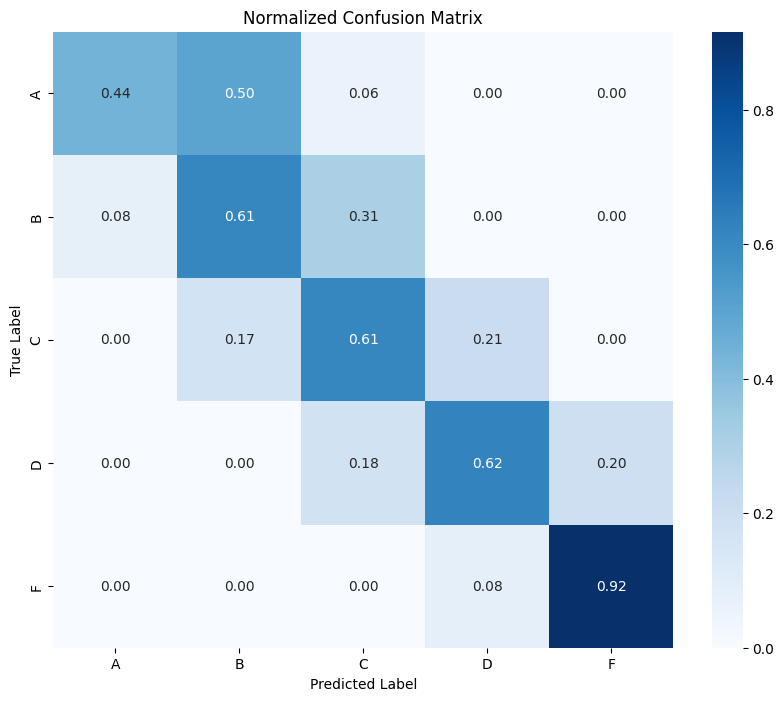

In [4]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

grade_classes = ["A", "B", "C", "D", "F"]
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
	xticklabels=grade_classes,
	yticklabels=grade_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()